# Time Series Analysis

This lecture summarizes the fundamental concepts and tools for analyzing time series data. Time series analysis is a branch of applied mathematics developed
mostly in the fields of signal processing and statistics. Contributions to this field, from an astronomical perspective, have predominantly focused on unevenly sampled data, low signal-to-noise data, and heteroscedastic errors. Even when limited to astronomical data sets, the diversity of potential applications is enormous. The most common applications range from the detection of variability and periodicity to the treatment of nonperiodic variability and searches for localized events.

Within time-domain data, measurement errors can range from as small as one
part in 100,000 to potential events buried in noise. Data sets can include many billions of data points, and sample sizes can be in the millions. Upcoming surveys, such as Gaia and LSST, will increase existing data sets by large factors. Scientific utilization of such data sets include searches for extrasolar planets; tests of stellar astrophysics through studies of variable stars and supernova explosions; distance determination (e.g., using standard candles such as Cepheids, RR Lyrae, and supernovas); and fundamental physics such as tests of general relativity with radio pulsars, cosmological studies with supernovas and searches for gravitational wave events.

The main tasks of time series analysis are 1) to characterize the presumed temporal correlation between different values of $y$, including its significance, and 2) to forecast future values of $y$.

## Modeling Toolkit for Time Series Analysis

The main tools for time series analysis belong to either the time domain or the
frequency domain. 

### Fourier Analysis

Fourier analysis plays a major role in the analysis of time series data. In Fourier analysis, general functions are represented or approximated by integrals or sums of simpler trigonometric functions. As first shown in 1822 by Fourier himself in
his analysis of heat transfer, this representation often greatly simplifies analysis. The code and figure below illustrates how an RR Lyrae light curve can be approximated by a sum
of sinusoids (details are discussed in later in this secion). The more terms that are included in the sum, the better is the resulting approximation. For periodic functions, such as periodic light curves in astronomy, it is often true that a relatively small number of terms (less than 10) suffices to reach an approximation precision level similar to the measurement precision.

The most useful applications of Fourier analysis include convolution and deconvolution, filtering, correlation and autocorrelation, and power spectrum estimation. The use of these
methods is by no means limited to time series data; for example, they are often used
to analyze spectral data or in characterizing the distributions of points. When the
data are evenly sampled and the signal-to-noise ratio is high, Fourier analysis can be
a powerful tool. When the noise is high compared to the signal, or the signal has a
complex shape (i.e., it is not a simple harmonic function), a probabilistic treatment
(e.g., Bayesian analysis) offers substantial improvements, and for irregularly (unevenly) sampled data probabilistic treatment becomes essential. For these reasons,
in the analysis of astronomical time series, which are often irregularly sampled with
heteroscedastic errors, Fourier analysis is often replaced by other methods Nevertheless, most of the main concepts introduced in Fourier analysis carry over to those other methods and thus
Fourier analysis is an indispensable tool when analyzing time series. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

templates = np.load('data/rrlyrae_templates.npy', allow_pickle=True)

plt.plot(templates[0]['t'], templates[0]['v'])

plt.title("Example of RR Lyrae cycle")
plt.xlabel("Phase")
plt.ylabel("Amplitude")
plt.show()

<Figure size 640x480 with 1 Axes>

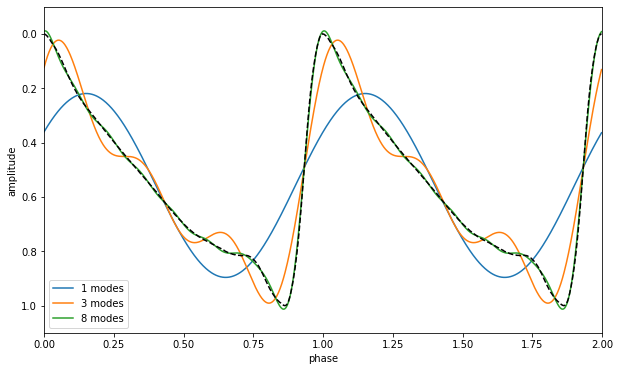

In [2]:
# Select rr lyrae 115g and cast data type to float (otherwise fft will complain)
x = templates[79]['t'].astype(np.float)
y = templates[79]['v'].astype(np.float)

# Create figure
fig = plt.figure(figsize=(10, 6))

# X values for two cycles (Catenate x with itself)
x = np.concatenate([x, 1 + x])

# Loop over several modes
for k in [1, 3, 8]:
    # Use FFT to fit a truncated Fourier series
    y_fft = np.fft.fft(y)
    y_fft[k + 1:-k] = 0
    y_fit = np.fft.ifft(y_fft).real

    # We'll plot two cycles (periods). Concatenate y/y_fit with itself
    new_y = np.concatenate([y, y])
    new_y_fit = np.concatenate([y_fit, y_fit])
        
    # Plot fit
    plt.plot(x, new_y_fit, label="{} modes".format(k))

# Plot original data
new_y = np.concatenate([y, y])
plt.plot(x, new_y, 'k--')
    
# Prettify
plt.legend()
plt.xlabel('phase')
plt.ylabel('amplitude')
plt.xlim(0, 2)
plt.ylim(1.1, -0.1)

# Show the plot
plt.show()

The Fourier Transofrm of a function $h(t)$ is defined as

$$
\begin{equation}
H(f) = \int^{\infty}_{-\infty} h(t)\,e^{(-i2\pi ft)}\,dt
\end{equation}
$$

with inverse transformation

$$
\begin{equation}
h(t) = \int^{\infty}_{-\infty} H(f)\,e^{(i2\pi ft)}\,df
\end{equation}
$$

where $t$ is time in seconds and $f$ is frequency in Hz.

#### Convolution Theorem

A convolution of two functions $a(t)$ and $b(t)$ is given by

$$
\begin{equation*}
(a*b)(t) \equiv \int^\infty_{-\infty} a(t')b(t-t')dt'
\end{equation*}
$$

Convolution is an unavoidable result of the measurement process because the measurement resolution, whether in time, spectral, spatial, or any other domain, is never infinite. For example, in astronomical imaging the true intensity distribution on the sky is convolved with the atmospheric seeing for ground-based imaging, or the telescope diffraction pattern for space-based imaging (radio astronomers use the term "beam convolution"). In the above equation, the function $a$ can be thought of as the "convolving pattern" of the measuring apparatus, and the function $b$ is the signal. In practice, we measure the convolved (or smoothed) version of our signal, $[a*b](t)$, and seek to uncover the original signal $b$ using the presumably known $a$.

The convolution theorem states that if $h=a*b$, then the Fourier transforms of $h$, $a$ and $b$ are related by their pointwise products:

$$
\begin{equation*}
H(f) = A(f)B(f)
\end{equation*}
$$

Thus a convolution of two functions is transformed into a simple multiplication of the associated Fourier representations. Therefore, to obtain $b$, we can simply take the inverse Fourier transform of the ratio $\frac{H(f)}{A(f)}$. In the absence of noise, this operation is exact. The figure below shows a schematic representation of the convolution theorem. The top-left panel shows simulated data (black line); this time series is convolved with a top-hat function (gray boxes). The top-right panels show the Fourier transform of the data and the window function. These can be multiplied together (bottom-right panel) and inverse transformed to find the convolution (bottom-left panel), which amounts to integrating the data over copies of the window at all locations. The result in the bottom-left panel can be viewed as a signal shown in the top-left panel smoothed with the window (top-hat) function. 

<img src="img/convolution.PNG">

Let's see how we can perform the above using Python:

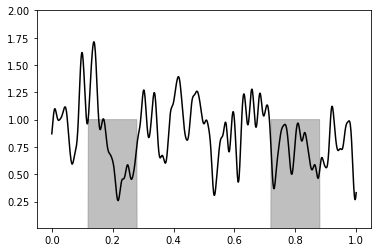

In [3]:
# Generate random x, y with a given covariance length
np.random.seed(1)
N = len(x)
x = np.linspace(0, 1, N)
h = 0.01
C = np.exp(-0.5 * (x - x[:, None]) ** 2 / h ** 2)
y = 0.8 + 0.3 * np.random.multivariate_normal(np.zeros(len(x)), C)

# Define a normalized top-hat window function
w = np.zeros_like(x)
w[(x > 0.12) & (x < 0.28)] = 1

# Plot the data and the window (windows is plotted twice, the
# second time around it's inverted)
plt.plot(x, y, 'k')
plt.fill(x, w, color='gray', alpha=0.5)
plt.fill(x, w[::-1], color='gray', alpha=0.5)
plt.ylim(0.01, 2)
plt.show()

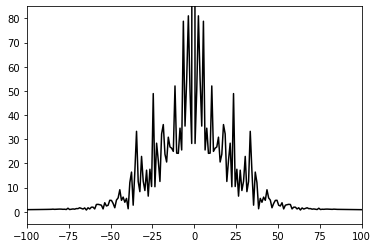

In [4]:
# Define x axis for plots
k = - 0.5 * N + np.arange(N) * 1. / N / (x[1] - x[0])

# Compute the Fourier transform of the signal
y_fft = np.fft.fft(y)

plt.plot(k, abs(np.fft.fftshift(y_fft)), '-k')
plt.xlim(-100, 100)
plt.ylim(-5, 85)
plt.show()

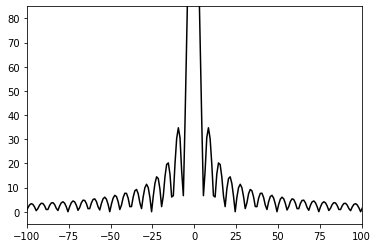

In [5]:
# Compute the Fourier transforms of the window
w_fft = np.fft.fft(w)

plt.plot(k, abs(np.fft.fftshift(w_fft)), '-k')
plt.xlim(-100, 100)
plt.ylim(-5, 85)
plt.show()

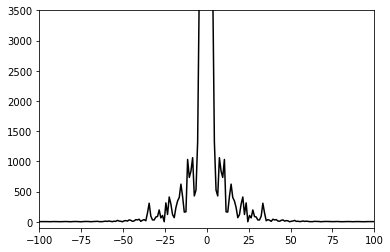

In [6]:
# Plot the product of Fourier transforms
yw_fft = y_fft * w_fft

plt.plot(k, abs(np.fft.fftshift(yw_fft)), '-k')

plt.xlim(-100, 100)
plt.ylim(-100, 3500)
plt.show()

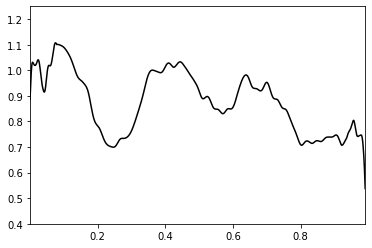

In [7]:
# Find the valid region and calculate normalization factor
y_norm = np.convolve(np.ones_like(y), w, mode='full')
valid_indices = (y_norm != 0)
y_norm = y_norm[valid_indices]

# Perform the convolution
y_w = np.convolve(y, w, mode='full')[valid_indices] / y_norm

# trick: convolve with x-coordinate to find the center of the window at each point.
x_w = np.convolve(x, w, mode='full')[valid_indices] / y_norm

plt.plot(x_w, y_w, '-k')
plt.xlim(0.001, 0.99)
plt.ylim(0.4, 1.25)
plt.show()

### Discrete Fourier Transform

In practice, data are always discretely sampled. When the spacing of the time interval is constant, the discrete Fourier transform is a powerful tool. In astronomy, temporal data are rarely sampled with uniform spacing (with exceptions) Nevertheless, uniformly sampled data is a good place to start, because of the very fast algorithms available for this situation, and because the primary concepts also extend to unevenly sampled data.

When computing the Fourier transform for discretely and uniformly sampled data, the Fourier integrals are translated to sums. Let us assume that we have a continuous real function $h(t)$ which is sampled at $N$ equal intervals $h_j=h(t_j)$ with $t_j \equiv t_0 + j\Delta t$, $j=0,...,(N-1)$, where the sampling interval $\Delta t$ and the duration of the data taking $T$ are related via $T = N\Delta t$. The discrete Fourier transform of the vector of values $h_j$ is a complex vector of length $N$ defined by

$$
\begin{equation*}
H_k = \sum^{N-1}_{j=0}h_j e^{-i(2\pi jk/N)}
\end{equation*}
$$

where $k=0,..,(N-1)$. The correpsonding inverse Fourier transform is defined by

$$
\begin{equation*}
h_j = \frac{1}{N}\sum^{N-1}_{k=0}H_k e^{i(2\pi jk/N)}
\end{equation*}
$$

where $j=0,..,(N-1)$. Unlike the continuous transform, here the units for $H_k$ are the same as the units for $h_j$. Given $H_k$, we can represent the function described by $h_j$ as a sum of sinusoids. 

#### The Nyquist sampling theorem

What is the relationship between the continuous transforms, where integration limits extend to infinity, and the discrete transforms, where the sums extend over sampled data? The answer is provided by the Nyquist sampling theorem (also known as Nyquist-Shannon theorem), an important result developed within the context of signal processing.

Let us define $h(t)$ to be *band limited* if $H(f)=0$ for $|f|>f_c$, where $f_c$ is the band limit, or the Nyquist critical frequency. If $h(t)$ is band limited, then there is some "resolution" limit in $t$ space, $t_c=1/(2f_c)$ below which $h(t)$ appears "smooth". When $h(t)$ is band limited, then according to the Nyquist sampling theorem we can *exactly reconstruct $h(t)$ from evenly sampled data when $\Delta t \leq t_c$*, as

$$
\begin{equation*}
h(t) = \frac{\Delta t}{t_c} \sum^{k=\infty}_{k=-\infty} h_k \frac{\sin{[2\pi f_c (t-k\Delta t)]}}{2\pi f_c (t-k\Delta t)}
\end{equation*}
$$

This result is known as the Whittaker-Shannon, or often just Shannon, interpolation formula. Note that the summation goes to infinity, but also the term multiplying $h_k$ vanished for large values $|t-k\Delta t|$. For example, $h(t)=\sin(2 \pi t/P)$ has a period $P$ and is band limited with $f_c=1/P$. If it is sampled with $\Delta t$ not larger than $P/2$, it can be fully reconstructed at any $t$ (it is important to note that this entire discussion assumes that there is no noise associated with sampled values $h_j$). On the other hand, when the sampled function $h(t)$ is not band limited, or when the sampling rate is not sufficient (i.e., $\Delta t > t_c$), an effect called "aliasing" prevents us from exactly reconstructing $h(t)$ (see figure below). In such a case, all of the power spectral density from frequencies $|f| > f_c$ is aliased (falsely transferred) into the range $-f_c < f < f_c$ range. The aliasing can be thought of as inability to resolve details in a time series at a finer detail than that set by $f_c$. The aliasing effect can be recognised if the Fourier transform is nonzero at $|f| = 1/(2\Delta t)$, as is also shown in the figure below. Therefore, the discrete Fourier transform is a good estimate of the true Fourier transform for properly sampled band limited functions.

<img width="80%" src="img/nyquist.PNG">

#### The window function

The figure above shows the relationship between sampling and the window function: the sampling window function in the time domain can be expressed as the sum of delta functions placed at sampled observation times. In this case the observations are regularly spaced. The Fourier transform of a set of delta functions with spacing $\Delta t$ is another set of delta functions with spacing $1/\Delta t$; this result is at the core of the
Nyquist sampling theorem. By the convolution theorem, pointwise multiplication of this sampling window with the data is equivalent to the convolution of their Fourier representations.

When data are nonuniformly sampled, the impact of sampling can be understood using the same framework. The sampling window is the sum of delta functions, but because the delta functions are not regularly spaced, the Fourier transform is a more complicated, and in general complex, function of $f$.

There are several different types of window functions that you can apply depending on the signal. To understand how a given window affects the frequency spectrum, you need to understand more about the frequency characteristics of windows. 

An actual plot of a window shows that the frequency characteristic of a window is a continuous spectrum with a main lobe and several side lobes. The main lobe is centered at each frequency
component of the time-domain signal, and the side lobes approach zero. The height of the side
lobes indicates the affect the windowing function has on frequencies around main lobes. The side lobe response of a strong sinusoidal signal can overpower the main lobe response of a nearby
weak sinusoidal signal. Typically, lower side lobes reduce leakage in the measured FFT but
increase the bandwidth of the major lobe. The side lobe roll-off rate is the asymptotic decay rate
of the side lobe peaks. By increasing the side lobe roll-off rate, you can reduce spectral leakage.

Selecting a window function is not a simple task. Each window function has its own
characteristics and suitability for different applications. To choose a window function, you must
estimate the frequency content of the signal.
-  If the signal contains strong interfering frequency components distant from the frequency of interest, choose a smoothing window with a high side lobe roll-off rate.
-  If the signal contains strong interfering signals near the frequency of interest, choose a window function with a low maximum side lobe level.
- If the frequency of interest contains two or more signals very near to each other, spectral resolution is important. In this case, it is best to choose a smoothing window with a very narrow main lobe.
- If the amplitude accuracy of a single frequency component is more important than the exact location of the component in a given frequency bin, choose a window with a wide main lobe.
- f the signal spectrum is rather flat or broadband in frequency content, use the uniform window, or no window.
- In general, the Hanning (Hann) window is satisfactory in 95 percent of cases. It has good frequency resolution and reduced spectral leakage. If you do not know the nature of the signal but you want to apply a smoothing window, start with the Hann window

Even if you use no window, the signal is convolved with a rectangular-shaped window of
uniform height, by the nature of taking a snapshot in time of the input signal and working
with a discrete signal. This convolution has a sine function characteristic spectrum. For this
reason, no window is often called the uniform or rectangular window because there is still
a windowing effect.

The Hamming and Hann window functions both have a sinusoidal shape. Both windows
result in a wide peak but low side lobes. However, the Hann window touches zero at both
ends eliminating all discontinuity. The Hamming window doesn’t quite reach zero and thus
still has a slight discontinuity in the signal. Because of this difference, the Hamming window
does a better job of cancelling the nearest side lobe but a poorer job of canceling any others.
These window functions are useful for noise measurements where better frequency
resolution than some of the other windows is wanted but moderate side lobes do not
present a problem.

The Blackman-Harris window is similar to Hamming and Hann windows. The resulting spectrum
has a wide peak, but good side lobe compression. There are two main types of this window. The
4-term Blackman-Harris is a good general-purpose window, having side lobe rejection in the high
90s dB and a moderately wide main lobe. The 7-term Blackman-Harris window function has all
the dynamic range you should ever need, but it comes with a wide main lobe.

The flat top window is sinusoidal, but it actually crosses the zero line. This causes a
much broader peak in the frequency domain, which is closer to the true amplitude of the
signal than with other windows.

These are just a few of the possible window functions. There is no universal approach for
selecting a window function. However, the table below can help you in your initial choice. Always
compare the performance of different window functions to find the best one for the application.

<img src="img/windows.PNG">


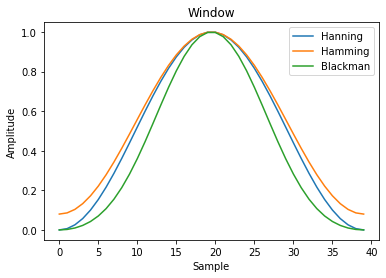

In [8]:
# Generating different windows using the appropriate functions in numpy
hanning_window = np.hanning(40) 
hamming_window = np.hamming(40) 
blackman_window = np.blackman(40) 

# Plot the windows
plt.plot(hanning_window, label="Hanning") 
plt.plot(hamming_window, label='Hamming') 
plt.plot(blackman_window, label='Blackman') 

plt.title("Window") 
plt.ylabel("Amplitude") 
plt.xlabel("Sample")   
plt.legend()
plt.show() 

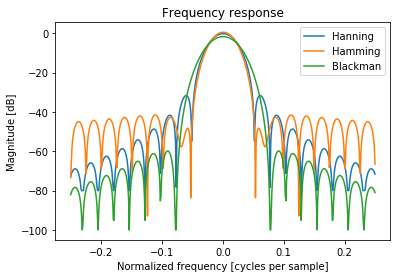

In [9]:
# Generate frequencies for x axis
n_points = 1000
frequencies = np.linspace(-0.25, 0.25, 500) 

# Get frequency responce for generating windows
fft = np.fft.fft(hanning_window, n_points) / 20
mag = np.abs(np.fft.fftshift(fft)[250:750]) 
hanning_response = 20 * np.log10(mag) 
hanning_response = np.clip(hanning_response, -80, 100) 

fft = np.fft.fft(hamming_window, n_points) / 20
mag = np.abs(np.fft.fftshift(fft)[250:750]) 
hamming_response = 20 * np.log10(mag) 
hamming_response = np.clip(hamming_response, -100, 100) 

fft = np.fft.fft(blackman_window, n_points) / 20
mag = np.abs(np.fft.fftshift(fft)[250:750]) 
blackman_response = 20 * np.log10(mag) 
blackman_response = np.clip(blackman_response, -100, 100) 

plt.plot(frequencies, hanning_response, label="Hanning") 
plt.plot(frequencies, hamming_response, label="Hamming") 
plt.plot(frequencies, blackman_response, label="Blackman") 
plt.title("Frequency response") 
plt.ylabel("Magnitude [dB]") 
plt.xlabel("Normalized frequency [cycles per sample]") 
plt.legend()
plt.show()

#### The fast Fourier transform

The Fast Fourier transform (FFT) is an algorithm for computing discrete Fourier transforms in $\mathcal{O}(N \log N)$ time, rather that $\mathcal{O}({N^2})$ using a naive implementation. The speed of FFT makes it a widespread tool in the analysis of evenly sampled, high signal-to-noise time series data

In [10]:
# The FFT and various related tools are available in Python through 
# the submodules numpy.fft and scipy.fftpack
from scipy import fftpack
import numpy as np

x = np.random.normal(size=1000) # White noise
x_fft = fftpack.fft(x) # Fourier transform
x2 = fftpack.ifft(x_fft) # inverse: x2==x to numerical precision

When computing a FFT we get complex numbers as a result. If we compare the first value of the sequence with the last value we can see that the real parts of both numbers are equal and that the value of the imaginary numbers are also equal in magnitude, only one is positive and the other is negative. The numbers are each others complex conjugate. This is true for all numbers in the sequence. For real number input $n$ is the complex conjugate of $N-n$.

Because the second half of the sequence gives us no new information we can already conclude that we only need half of the FFT sequence. The complex output numbers of the FFT contain the following information:
* *Amplitude* of a certain frequency sine wave (energy)
* *Phase* offset of a certain frequency sine wave

The amplitude is retrieved by taking the absolute value of the number and the phase offset is obtained by computing the angle of the number. 

The example below presents such an analysis for a function with a single dominant frequency: a sine wave whose amplitude is modulated by a Gaussian. It also shows the results in the presence of noises.

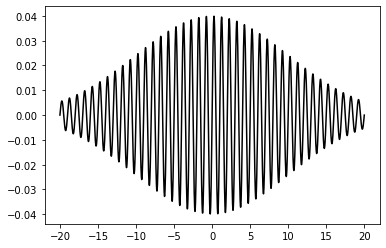

In [11]:
from scipy.stats import norm

# Generate data
np.random.seed(1)

N = 2048
time = np.linspace(-20, 20, 2048)
data = np.sin(2 * np.pi * time) * norm(0, 10).pdf(time)

plt.plot(time, data, '-k')
plt.show()

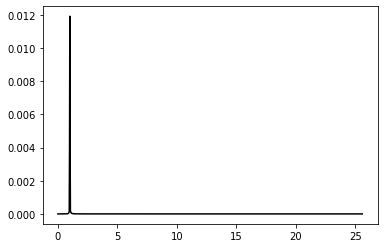

In [12]:
# Looks at the data's fourier components
T = time[1] - time[0]
freqs = np.linspace(0, 1/T, 2048)

ffted_data = np.fft.fft(data)

# Show (1/N is a normalisation factor)
plt.plot(freqs[:N // 2], np.abs(ffted_data)[:N // 2] * 1 / N, '-k')
plt.show()

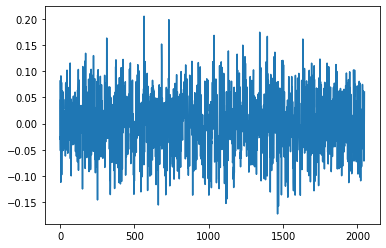

In [13]:
# Let's add some noise
err_data = data + np.random.normal(0, 0.05, size=data.shape)

plt.plot(err_data)
plt.show()

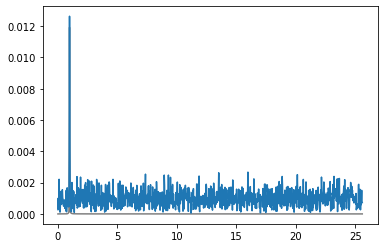

In [14]:
# And see the frequency components of the corrupted data
err_ffted_data = np.fft.fft(err_data)

# Show (1/N is a normalisation factor)
plt.plot(freqs[1:N // 2], np.abs(ffted_data)[1:N // 2] * 1 / N, '-k', alpha=0.5)
plt.plot(freqs[1:N // 2], np.abs(err_ffted_data)[1:N // 2] * 1 / N)
plt.show()

The discrete Fourier transform can be a powerful tool even when data are not periodic. A good example is estimating the power spectrum for noise that is not white. In the below, we compute the noise power spectrum for a stream of time series data from LIGO. The measurement noise is far from white: it has a minimum at frequencies of a few hundred hertz (the minimum level is related to the number of photons traveling through the interferometers), and increases rapidly at smaller frequencies due to a number of instrumental effects. The predicted signal strengths are at best a few times stronger than the noise level and thus precise noise characterization is a prerequisite for robust detection of gravitational waves. 

For noisy data with many samples, more sophisticated FFT-based methods can be used to improve the signal-to-noise ratio of the resulting PSD, at the expense of frequency resolution. One well known method is Welch's method, which computes multiple Fourier transforms over overlapping windows of the data to smooth noise effects in the resuling spectrum. The Hanning window suppresses noise and better picks up features at high frequencies, at the expense of affecting the shape of the continuum.

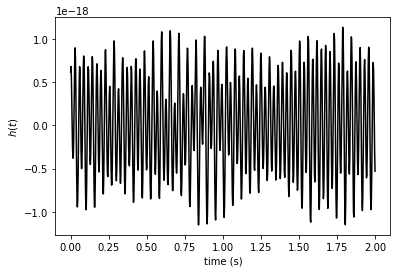

In [15]:
from matplotlib import mlab
import numpy as np

# Load LIGO data
data = np.load("data/ligo.npy")

# Define parameters
dt = 0.000244140625
fmax = 2060
fmin = 40

# Subset of the data to plot
t0, T = 646, 2
tplot = dt * np.arange(T * 4096)
dplot = data[4096 * t0: 4096 * (t0 + T)]

# Plot the data
plt.plot(tplot[::10], dplot[::10], '-k')
plt.xlabel('time (s)')
plt.ylabel('$h(t)$')
plt.show()

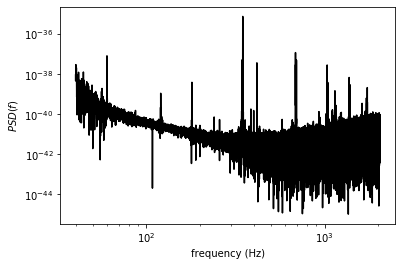

In [16]:
# Compute PSD using simple FFT
N = len(data)
df = 1. / (N * dt)
PSD = abs(dt * fftpack.fft(data)[:N // 2]) ** 2
f = df * np.arange(N / 2)

cutoff = ((f >= fmin) & (f <= fmax))
f = f[cutoff]
PSD = PSD[cutoff]
f = f[::100]
PSD = PSD[::100]

plt.loglog(f, PSD, '-k')
plt.xlabel('frequency (Hz)')
plt.ylabel(r'$PSD(f)$')
plt.show()


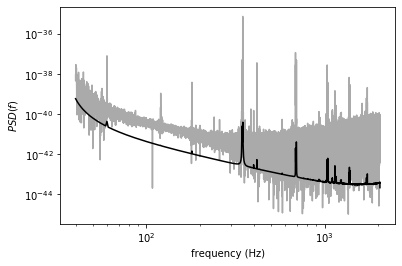

In [17]:
# Compute PSD using Welch's method and no window function
PSDW1, fW1 = mlab.psd(data, NFFT=4096, Fs=1. / dt,
                      window=mlab.window_none, noverlap=2048)

dfW1 = fW1[1] - fW1[0]

cutoff = (fW1 >= fmin) & (fW1 <= fmax)
fW1 = fW1[cutoff]
PSDW1 = PSDW1[cutoff]

plt.loglog(f, PSD, '-', c='#AAAAAA')
plt.loglog(fW1, PSDW1, '-k')
plt.xlabel('frequency (Hz)')
plt.ylabel(r'$PSD(f)$')
plt.show()

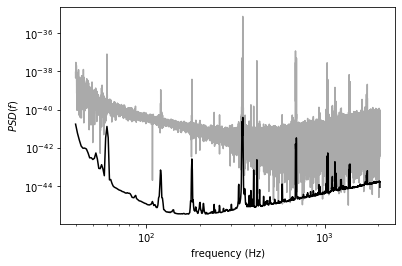

In [18]:
# Compute PSD using Welch's method and hanning window function
PSDW2, fW2 = mlab.psd(data, NFFT=4096, Fs=1. / dt,
                      window=mlab.window_hanning, noverlap=2048)

dfW2 = fW2[1] - fW2[0]

cutoff = (fW2 >= fmin) & (fW2 <= fmax)
fW2 = fW2[cutoff]
PSDW2 = PSDW2[cutoff]

plt.loglog(f, PSD, '-', c='#AAAAAA')
plt.loglog(fW2, PSDW2, '-k')
plt.xlabel('frequency (Hz)')
plt.ylabel(r'$PSD(f)$')
plt.show()

### Digital Filtering

Digital filtering aims to reduce noise in time series data, or to
compress data. Common examples include low-pass filtering, where high frequencies are suppressed, high-pass filtering, where low frequencies are
suppressed, passband filtering, where only a finite range of frequencies is admitted, and a notch filter, where a finite range of frequencies is blocked. Fourier analysis is one of the most useful tools for performing filtering. We'll look at low pass filters here to get an idea of what filtering does.

Filtering always decreases the information content of data
(despite making it appear less noisy). When model parameters are estimated from data, raw (unfiltered) data should be used. In some sense, this is an analogous situation to binning data to produce a histogram—while very useful for visualization, estimates of model parameters can become biased if one is not careful.

#### Low-pass filters

The power spectrum for common Gaussian noise is flat and will extend to frequencies as high as the Nyquist limit, $_N=1/(2 \Delta t)$. If the data are band limited to a lower frequency, $f_c < f_N$, then they can be smooted without much impact by supressing frequencies $|f| > f_c$. Given a filter in frequency space, $\Phi(f)$, we can obtain a smoothed version of data by taking the inverse Fourier transform of

$$
\begin{equation*}
\hat{Y}(f) = Y(f)\Phi (f)
\end{equation*}
$$

where $Y(f)$ is the discrete Fourier transform of data. At least in principle, we could simply set $\Phi(f)$ to zero for $|f|>f_c$, but this approach would result in ringing (unwanted oscillations) in the signal. Instead, the optimal filter for this purpose is constructed by minimising the minimum integrated square error (MISE) between $\hat{Y}(f)$ and $Y(f)$, and is called the Wiener filter:

$$
\begin{equation*}
\Phi{f} = \frac{P_S(f)}{P_S(f) + P_N(f)}
\end{equation*}
$$

Here $P_S(f)$ and $P_N(f)$ represent components of a two-component (signal and noise) fit to the PSD of input data, $\texttt{PSD}_Y(f) = P_S(f) + P_N(f)$, which holds as long as the signal and noise are uncorrelated. Given some assumed form of signal and noise, these terms can be determined from a fit to the observed PSD, as illustrated in the example below. Even when the fidelity of the PSD is not high, the resulting filter performs well in practice (the key features are that $\Phi(f) \sim 1$ at small frequencies and that it drops to zero at high frequencies for a band-limited signal)

In [19]:
# There is a basic Wiener filter implementation in scipy.signal.wiener,
# based on assumptions of the local data mean and variance. The function
# below implements a wiener filter on the more sophisticated procedure
# outlined above

def wiener_filter(time_series, data):
    """Compute a Wiener-filtered time-series """

    # Compute the PSD of the input
    N = len(time_series)
    Df = 1. / N / (time_series[1] - time_series[0])
    f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
    H = fftpack.fft(data)
    PSD = abs(H) ** 2

    # Fit signal/noise params
    amp_guess = np.max(PSD[1:])
    width_guess = np.min(np.abs(f[PSD < np.mean(PSD[1:])]))
    signal_params = (amp_guess, width_guess)
    noise_params = (np.mean(PSD[1:]), )

    # Set up the Wiener filter:
    def signal(x, A, width):
        width = abs(width) + 1E-99  # prevent divide-by-zero errors
        return A * np.exp(-0.5 * (x / width) ** 2)

    def noise(x, n):
        return n * np.ones(x.shape)

    # Minimize MISE, avoiding DC bin
    min_func = lambda v: np.sum((PSD[1:] - signal(f[1:], v[0], v[1])
                                 - noise(f[1:], v[2])) ** 2)
    v0 = tuple(signal_params) + tuple(noise_params)
    v = optimize.minimize(min_func, v0, method='Nelder-Mead')['x']

    P_S = signal(f, v[0], v[1])
    P_N = noise(f, v[2])
    Phi = P_S / (P_S + P_N)
    Phi[0] = 1  # correct for DC offset

    # Use Phi to filter and smooth the values
    h_smooth = fftpack.ifft(Phi * H)

    return h_smooth.real, PSD, P_S, P_N, Phi

The below provides an example of data filtering using a Wiener filter. The upper-left panel shows noisy input data (200 evenly spaced points) with a narrow Gaussian peak at x = 20. The bottom panels show the input (left) and Wiener-filtered (right) power spectral density (PSD) distributions. The two curves in the bottom-left panel represent two-component fit to PSD. The upper right panel shows the result of the Wiener filtering on the input: the Gaussian peak is clearly seen.

Text(0.5, 0, '$f$')

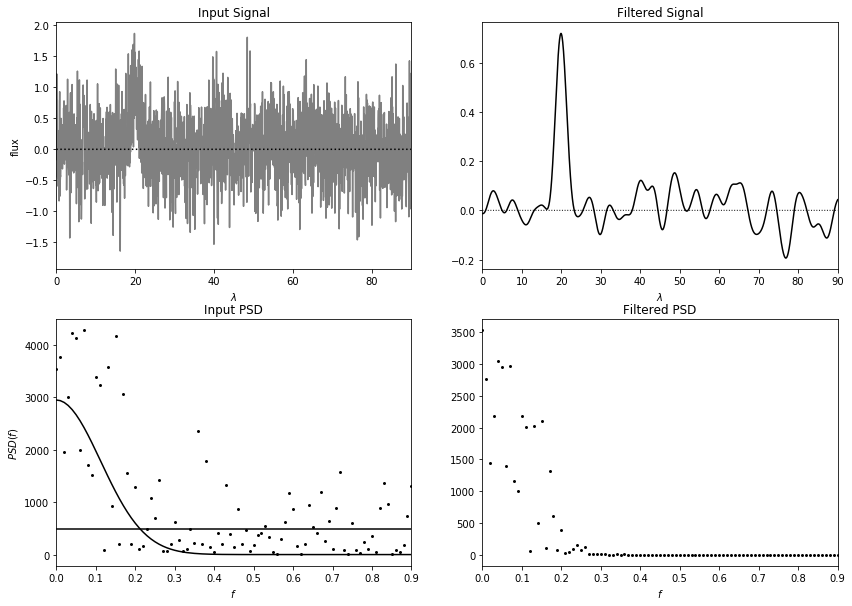

In [20]:
import matplotlib.pyplot as plt
from scipy import fftpack, optimize
import numpy as np

np.random.seed(5)
N = 2000
dt = 0.05

t = dt * np.arange(N)
h = np.exp(-0.5 * ((t - 20.) / 1.0) ** 2)
hN = h + np.random.normal(0, 0.5, size=h.shape)

Df = 1. / N / dt
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
HN = fftpack.fft(hN)

# Set up the Wiener filter:
h_smooth, PSD, P_S, P_N, Phi = wiener_filter(t, hN)

# Plot the results
N = len(t)
Df = 1. / N / (t[1] - t[0])
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
HN = fftpack.fft(hN)

fig = plt.figure(figsize=(14, 10))

# First plot: noisy signal
ax = fig.add_subplot(221)
ax.plot(t, hN, '-', c='gray')
ax.plot(t, np.zeros_like(t), ':k')
ax.set_title("Input Signal")
ax.set_xlim(0, 90)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('flux')

# Second plot: filtered signal
ax = plt.subplot(222)
ax.plot(t, np.zeros_like(t), ':k', lw=1)
ax.plot(t, h_smooth, '-k', lw=1.5,)
ax.set_title("Filtered Signal")
ax.set_xlim(0, 90)
ax.set_xlabel(r'$\lambda$')

# Third plot: Input PSD
ax = fig.add_subplot(223)
ax.scatter(f[:N // 2], PSD[:N // 2], s=9, c='k', lw=0)
ax.plot(f[:N // 2], P_S[:N // 2], '-k')
ax.plot(f[:N // 2], P_N[:N // 2], '-k')
ax.set_title( "Input PSD")
ax.set_xlim(0, 0.9)
ax.set_xlabel('$f$')
ax.set_ylabel('$PSD(f)$')

# Fourth plot: Filtered PSD
ax = fig.add_subplot(224)
filtered_PSD = (Phi * abs(HN)) ** 2
ax.scatter(f[:N // 2], filtered_PSD[:N // 2], s=9, c='k', lw=0)
ax.set_title("Filtered PSD")
ax.set_xlim(0, 0.9)
ax.set_xlabel('$f$')
